###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensor import Tensor
from nn import MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

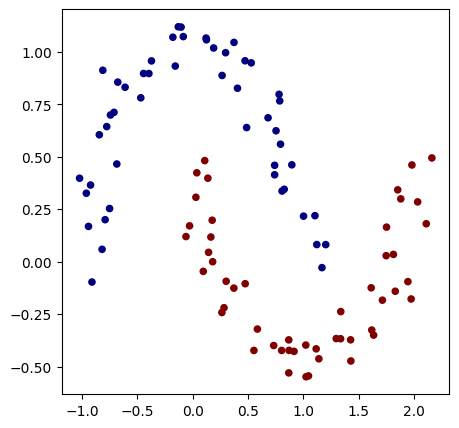

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
def relu_like(x):
    """ReLU-like function that maintains computational graph"""
    data = np.maximum(0, x.data)
    out = Tensor(data, requires_grad=x.requires_grad)
    
    def _backward():
        if x.requires_grad:
            x.grad += (x.data > 0) * out.grad
    
    out._backward = _backward
    out._prev = {x}
    return out

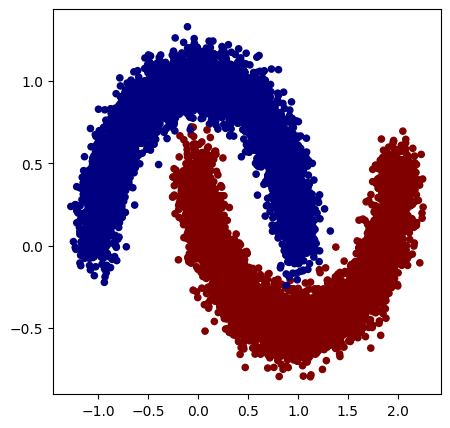

step 0 loss 0.9754, accuracy 65.4%
step 10 loss 0.2045, accuracy 90.6%
step 20 loss 0.1740, accuracy 92.1%
step 30 loss 0.1240, accuracy 94.7%
step 40 loss 0.0667, accuracy 98.3%
step 50 loss 0.0384, accuracy 99.4%
step 60 loss 0.0291, accuracy 99.6%
step 70 loss 0.0263, accuracy 99.7%
step 80 loss 0.0247, accuracy 99.8%
step 90 loss 0.0238, accuracy 99.8%


In [6]:

np.random.seed(1337)
random.seed(1337)
from sklearn.datasets import make_moons, make_blobs

# Generate data
X, y = make_moons(n_samples=10000, noise=0.1)
y = y * 2 - 1  # make y be -1 or 1

# Visualize
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')
plt.show()

model = MLP(2, 16, 32, 1)

# FIXED loss function
def compute_loss(batch_size=None):
    # Data sampling
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = Tensor(Xb, requires_grad=False)
    targets = Tensor(yb.reshape(-1, 1), requires_grad=False)
    
    # Forward pass
    scores = model(inputs)
    
    # SVM hinge loss - PROPERLY IMPLEMENTED
    # margin = max(0, 1 - y * score) for each sample
    margin = Tensor(1.0) - targets * scores
    
    # Apply ReLU to get hinge loss (maintains computational graph)
    hinge_loss = relu_like(margin)
    data_loss = hinge_loss.sum() * (1.0 / len(yb))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = Tensor(0.0)
    for p in model.parameters():
        reg_loss = reg_loss + (p * p).sum()
    reg_loss = reg_loss * alpha
    
    total_loss = data_loss + reg_loss
    
    # Accuracy calculation
    accuracy = np.mean((yb > 0) == (scores.data.flatten() > 0))
    
    return total_loss, accuracy

# Training loop
for k in range(100):
    # Forward pass
    total_loss, acc = compute_loss()
    
    # Backward pass
    model.zero_grad()
    total_loss.backward()
    
    # Update parameters (SGD)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data:.4f}, accuracy {acc*100:.1f}%")

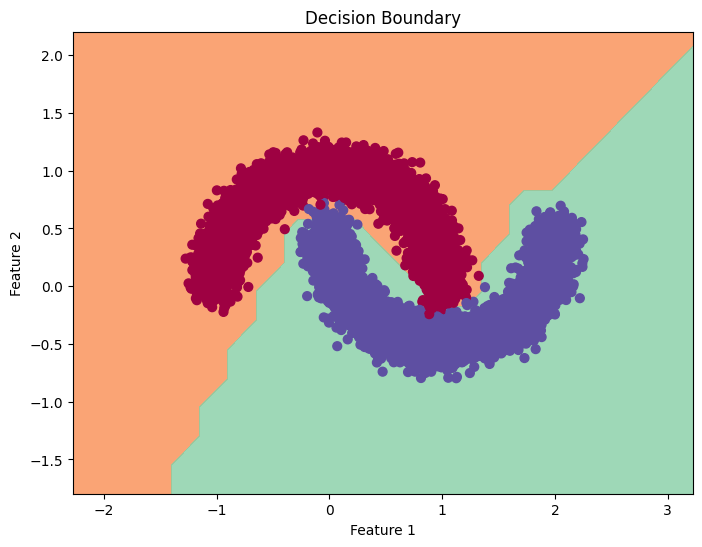

In [7]:

# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# Convert to Tensor and get predictions
mesh_tensor = Tensor(Xmesh, requires_grad=False)
scores = model(mesh_tensor)
Z = np.array(scores.data > 0).flatten()
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()